In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.pothook_analysis_lib import *
from torchvision.transforms import ToTensor, ToPILImage, Pad, Compose
from torchvision.utils import make_grid
from core.utils.CNN_scorers import resize_and_pad_tsr

In [3]:
# set variabels
pd_key="expriment_meta_data_df"
proc_data_root = r"N:\PonceLab\Users\Alireza\insilico_experiments\BigGAN_expriment_processed_data_and_results"
rawdata_root = r"N:\PonceLab\Users\Alireza\insilico_experiments\BigGAN_reconstruction_O2_rawdata"
save_root = os.path.join(proc_data_root, "results_poster")
os.makedirs(save_root, exist_ok=True)

In [4]:
# metadata loading
"""
data_path = os.path.join(proc_data_root, "metadata_dfs_preprocessed_but_seprated") 
meta_data_df = pd.DataFrame()
for file in os.listdir(data_path):
    if file.endswith(".h5"):
        meta_data_df = pd.concat([meta_data_df, pd.read_hdf(os.path.join(data_path, file), key=pd_key)], axis=0)
concated_df_path = os.path.join(proc_data_root, "metadata_dfs_preprocessed_concated")
os.makedirs(concated_df_path, exist_ok=True)
meta_data_df.to_hdf(os.path.join(concated_df_path, "meta_data_df.h5"), key=pd_key)
"""
concated_df_path = os.path.join(proc_data_root, "metadata_dfs_preprocessed_concated")
metadata_df_cosine = pd.read_hdf(os.path.join(concated_df_path, "meta_data_df.h5"), key=pd_key)

In [5]:
metadata_df_cosine.head()

,output_type,trget_imge_name,similarity_metric,pop_size,pop_resampling_id,gan_name,layer_name,layer_short,net_name,img_size,...,score,pop_unit_idx,sub_pop_type,gen_rerun_id,data_root,sim_index,l2_distance,sim_index_l1,sim_index_l2,l2_distance_normalized
1691322288_575271,target_img,imagenet_18,cosine,128,0,BigGAN,[.features.Conv2d3],conv2,alexnet,None,...,NaN,"{'.features.Conv2d3': [39001, 7654, 90760, 805...",most,None,/n/scratch3/users/a/ala2226/BigGAN_reconstruct...,NaN,NaN,NaN,NaN,NaN
1691322288_620874,target_img_RF_masked,imagenet_18,cosine,128,0,BigGAN,[.features.Conv2d3],conv2,alexnet,None,...,NaN,"{'.features.Conv2d3': [39001, 7654, 90760, 805...",most,None,/n/scratch3/users/a/ala2226/BigGAN_reconstruct...,NaN,NaN,NaN,NaN,NaN
1691322315_3751399,generation_data,imagenet_18,cosine,128,0,BigGAN,[.features.Conv2d3],conv2,alexnet,None,...,0.786798,"{'.features.Conv2d3': [39001, 7654, 90760, 805...",most,0,/n/scratch3/users/a/ala2226/BigGAN_reconstruct...,NaN,NaN,NaN,NaN,NaN
1691322315_9398477,best_gen_imgs,imagenet_18,cosine,128,0,BigGAN,[.features.Conv2d3],conv2,alexnet,None,...,0.786798,"{'.features.Conv2d3': [39001, 7654, 90760, 805...",most,0,/n/scratch3/users/a/ala2226/BigGAN_reconstruct...,NaN,NaN,NaN,NaN,NaN
1691322315_6956331,best_gen_imgs_RF_masked,imagenet_18,cosine,128,0,BigGAN,[.features.Conv2d3],conv2,alexnet,None,...,0.786798,"{'.features.Conv2d3': [39001, 7654, 90760, 805...",most,0,/n/scratch3/users/a/ala2226/BigGAN_reconstruct...,NaN,8.60561,0.63596,0.59667,0.005628


In [4]:
# fix the root path of the data in the metadata_df_cosine
metadata_df_cosine_server_path = metadata_df_cosine.copy()
O2_server_path = r'/n/scratch3/users/a/ala2226/BigGAN_reconstruction_O2_080123/'
local_path = r'N:\PonceLab\Users\Alireza\insilico_experiments\BigGAN_reconstruction_O2_rawdata'+'\\'
metadata_df_cosine['data_root'] = metadata_df_cosine['data_root'].apply(lambda path: path.replace(O2_server_path, local_path))


In [7]:
# print target images and the its recontruction for each layer and population size (load all regen images)
image_name_list = metadata_df_cosine["trget_imge_name"].unique()
image_name_list = {"imagenet_116", "imagenet_8", "invar_1", "n08524735_17105"}
layer_short_list = ["conv5", "conv4", "conv3", "conv2"]
similarity_metric_list = ["cosine", "MSE"]
pop_size_list = [2, 8, 32, 128]
RF_treshold = 2
pop_resampling_id = 0
smpling_type = "most"

output_type = "target_img_RF_masked"
gen_image_type = "best_gen_imgs_RF_masked"

# load the recontruction image for each layer and plot them in a grid 
# each row is a layer and each column is a population size
save_path_per = os.path.join(save_root, f"recontruction_images_{smpling_type}")
for similarity_metric in similarity_metric_list:
    save_path = os.path.join(save_path_per, similarity_metric)
    os.makedirs(save_path, exist_ok=True)
    for image_name in image_name_list:
        fig, ax = plt.subplots(len(layer_short_list), len(pop_size_list)+1, figsize=(20, 20))
        for i, layer_short in enumerate(layer_short_list):
            target_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name,
                                        layer_short=layer_short, output_type=output_type, pop_size=pop_size_list[-2],
                                        sub_pop_type=smpling_type, pop_resampling_id=pop_resampling_id, similarity_metric=similarity_metric)
                                        
            rf_filter = np.load(os.path.join(proc_data_root, "rf_filters", f"{layer_short}_{pop_size_list[-2]}.npz"))
            target_image_croped = image_rf_crop(target_image, (int(rf_filter["sigma_y"]*RF_treshold*2),
                                                            int(rf_filter["sigma_x"]*RF_treshold*2)))
            # show the target image
            ax[i, 0].imshow(ToPILImage()(target_image_croped))
            ax[i, 0].set_title(f"target image", fontsize=23, fontweight="bold")
            # set x label
            ax[i, 0].set_ylabel(f"{layer_short}", fontsize=27, fontweight="bold")
            # remove just y axix
            ax[i, 0].set_xticks([])
            ax[i, 0].set_yticks([])
            for j, pop_size in enumerate(pop_size_list):
                try:
                    # load the recontruction image for each gen_rerun_id and append it to a tensor
                    rcon_score_list = []
                    for gen_rerun_id in range(5):
                        recontruction_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                            output_type=gen_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                            similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                                            pop_resampling_id=pop_resampling_id)

                        # load the RF mask
                        rf_filter = np.load(os.path.join(proc_data_root, "rf_filters", f"{layer_short}_{pop_size}.npz"))
                        # crop the recontruction image
                        recontruction_image_croped = image_rf_crop(recontruction_image, (int(rf_filter["sigma_y"]*RF_treshold*2),
                                                                                        int(rf_filter["sigma_x"]*RF_treshold*2)))
                        rcon_score_list.append(column_inquary("score", metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                        output_type=gen_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                        similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                                        pop_resampling_id=pop_resampling_id))
                        if gen_rerun_id == 0:
                            recontruction_image_tensor = recontruction_image_croped.unsqueeze(0)
                        else:
                            recontruction_image_tensor = torch.cat((recontruction_image_tensor, recontruction_image_croped.unsqueeze(0)), dim=0)
                    rcon_score = np.mean(rcon_score_list)        
                    recontruction_image_grid = make_grid(recontruction_image_tensor, padding= 2, pad_value= 1, nrow=2)
                    # show the recontruction image           
                    ax[i, j+1].imshow(ToPILImage()(recontruction_image_grid))
                    # title with score and pop_size and bold
                    ax[i, j+1].set_title(f"score: {rcon_score:.2f} ", fontsize=23, fontweight="bold")
                except:
                    pass
                ax[i, j+1].axis("off")
        plt.tight_layout()
        # save the figure  
        plt.savefig(os.path.join(save_path, f"{image_name}_{similarity_metric}_recontruction_all_gen_{smpling_type}.png"), bbox_inches="tight", pad_inches=0)
        plt.close()
        print(f"Done {image_name}_{similarity_metric}...")


Done invar_1_cosine...
Done imagenet_116_cosine...
Done imagenet_8_cosine...
Done n08524735_17105_cosine...
Done invar_1_MSE...
Done imagenet_116_MSE...
Done imagenet_8_MSE...
Done n08524735_17105_MSE...


In [ ]:
# plot imgae generation teragectory for each 

image_name_list = metadata_df_cosine["trget_imge_name"].unique()
layer_short_list = ["conv5", "conv4", "conv3", "conv2"]
similarity_metric_list = ["cosine", "MSE"]
smpling_types = {"most", 'random'}
pop_size = 128
gen_rerun_id = 1
pop_resampling_id = 1
save_path_root = os.path.join(save_root, f"generatoin_tragectory_popsize{pop_size}")
for smpling_type in smpling_types:   
    save_path_image_root = os.path.join(save_path_root, smpling_type)
    for i, layer_short in enumerate(layer_short_list):
        save_path_layer = os.path.join(save_path_image_root, layer_short)
        for similarity_metric in similarity_metric_list:
            save_path = os.path.join(save_path_layer, similarity_metric)
            os.makedirs(save_path, exist_ok=True)
            for image_name in image_name_list:
                for gen_rerun_id in range(5):
                    fig, ax = plt.subplots(figsize=(20, 20))
                    generation_tragectory = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                        output_type="best_in_each_gen_imgs_RF_masked", pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                        similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                                        pop_resampling_id=pop_resampling_id)
                    ax.imshow(ToPILImage()(generation_tragectory))
                    ax.set_title(f"generation tragectory for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")
                    ax.axis("off")
                    # save the figure 
                    plt.savefig(os.path.join(save_path, f"{image_name}_tragectory_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}_fr_masked.jpg"), bbox_inches="tight", pad_inches=0)
                    plt.close()

                    fig, ax = plt.subplots(figsize=(20, 20))
                    generation_tragectory = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                        output_type="best_in_each_gen_imgs", pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                        similarity_metric=similarity_metric, sub_pop_type=smpling_type,
                                                        pop_resampling_id=pop_resampling_id)
                    ax.imshow(ToPILImage()(generation_tragectory))
                    ax.set_title(f"generation tragectory for {similarity_metric} objective function \n and {layer_short} layer and #{gen_rerun_id} generation rerun")
                    ax.axis("off")
                    # save the figure 
                    plt.savefig(os.path.join(save_path, f"{image_name}_tragectory_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}_non_masked.jpg"), bbox_inches="tight", pad_inches=0)
                    plt.close()
                    print(f"saved {image_name}_tragectory_{layer_short}_{similarity_metric}_{gen_rerun_id}_{smpling_type}.jpg")


In [ ]:
# intera layer recontruction image generation
import matplotlib as mpl
import time
color_map_name_cosine = "jet"
pading_cmap_cosine=mpl.colormaps[color_map_name_cosine]
color_map_name_MSE = "jet"
pading_cmap_MSE=mpl.colormaps[color_map_name_MSE]

def addhock_normalization(inval, minval, maxval):
    return (inval - minval) / (maxval - minval)

cosine_min = .75
cosine_max = 1
MSE_min = -25
MSE_max = 3
image_name_list = metadata_df_cosine["trget_imge_name"].unique()
layer_short_list = ["conv5", "conv5432", "conv53"]
similarity_metric_list = ["cosine", "MSE"]
smpling_type_list = ["most", "random"]
pop_size_list = [8, 16, 32, 64, 128, 256]
each_layer_pop_size_coeff = [1, .25, .5]
RF_treshold = 2
pop_resampling_id = 0
output_type = "target_img_RF_masked"
gen_image_type = "best_gen_imgs_RF_masked"
save_path_root = os.path.join(save_root, "inter_layer_intra_layer_comparision")
initTime = time.time()
for sampling_type in smpling_type_list:
    save_path_sampling_type = os.path.join(save_path_root, sampling_type)
    padding = 3
    num_of_reconstruction_repetitions = metadata_df_cosine["gen_rerun_id"].max()+1
    for similarity_metric in similarity_metric_list:
        save_path = os.path.join(save_path_sampling_type, similarity_metric)
        os.makedirs(save_path, exist_ok=True)
        for image_name in image_name_list:
            # make a sub plot grid of size (3, len(layer_short_list)) the ratio of the row is 3:1:3
            fig, ax = plt.subplots( len(layer_short_list)+1 ,len(pop_size_list), figsize=(18, 15), gridspec_kw={'height_ratios': [1, 3, 3, 3]})
            for i, real_pop_size in enumerate(pop_size_list):
                
                layer_short = "conv5"
                target_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, pop_resampling_id=pop_resampling_id,
                                            layer_short=layer_short, output_type=output_type, pop_size=real_pop_size, sub_pop_type=sampling_type,
                                            similarity_metric=similarity_metric)
                rf_filter = np.load(os.path.join(proc_data_root, "rf_filters", f"{layer_short}_{real_pop_size}.npz"))
                target_image_croped = image_rf_crop(target_image, (int(rf_filter["sigma_y"]*RF_treshold*2),
                                                                int(rf_filter["sigma_x"]*RF_treshold*2)))
                # show the target image
                ax[0, i].imshow(ToPILImage()(target_image_croped))
                ax[0, i].set_xticks([])
                ax[0, i].set_yticks([])
                # load the recontruction image for each gen_rerun_id and append it to a tensor
                
                for j, layer_short in enumerate(layer_short_list):
                    pop_size = int(real_pop_size*each_layer_pop_size_coeff[j])
                    rcon_score_list = []
                    for gen_rerun_id in range(num_of_reconstruction_repetitions):
                        recontruction_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                            output_type=gen_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                            similarity_metric=similarity_metric, sub_pop_type=sampling_type, pop_resampling_id=pop_resampling_id,)
                        # crop the recontruction image
                        recontruction_image_croped = image_rf_crop(recontruction_image, (int(rf_filter["sigma_y"]*RF_treshold*2),
                                                                                        int(rf_filter["sigma_x"]*RF_treshold*2)))
                        score = column_inquary("score", metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                        output_type=gen_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                        similarity_metric=similarity_metric, sub_pop_type=sampling_type)
                        rcon_score_list.append(score)
                        if similarity_metric == "cosine":
                            norm_score = addhock_normalization(score, cosine_min, cosine_max)
                            recontruction_image_croped = add_padding(recontruction_image_croped, int(padding+(padding/(i+1))), pading_cmap_cosine(norm_score)[:3])
                        elif similarity_metric == "MSE":
                            norm_score = addhock_normalization(score, MSE_min, MSE_max)
                            recontruction_image_croped = add_padding(recontruction_image_croped, int(padding+(padding/(i+1))), pading_cmap_MSE(norm_score)[:3])
                        if gen_rerun_id == 0:
                            recontruction_image_tensor = recontruction_image_croped.unsqueeze(0)
                        else:
                            recontruction_image_tensor = torch.cat((recontruction_image_tensor, recontruction_image_croped.unsqueeze(0)), dim=0)
                    rcon_score = np.mean(rcon_score_list)        
                    recontruction_image_grid = make_grid(recontruction_image_tensor, padding= 3, pad_value= 1, nrow=2)
                    # show the recontruction image           
                    ax[j+1, i].imshow(ToPILImage()(recontruction_image_grid))
                    ax[j+1, i].axis("off")
                    # set tight layout       
            plt.tight_layout()
            # save the figure 
            
            plt.savefig(os.path.join(save_path, f"{image_name}_{similarity_metric}_{sampling_type}.png"), bbox_inches="tight", pad_inches=0, dpi=300)
            plt.close()
            finishTime = time.time()
            print(f"Done {image_name}_{similarity_metric} in {finishTime-initTime} seconds")
            initTime = finishTime


In [244]:
# intera layer recontruction image generation, fewer popsize
import matplotlib as mpl
import time
color_map_name_cosine = "jet"
pading_cmap_cosine=mpl.colormaps[color_map_name_cosine]
color_map_name_MSE = "jet"
pading_cmap_MSE=mpl.colormaps[color_map_name_MSE]

def addhock_normalization(inval, minval, maxval):
    return (inval - minval) / (maxval - minval)

cosine_min = .75
cosine_max = 1
MSE_min = -25
MSE_max = 3
#image_name_list = metadata_df_cosine["trget_imge_name"].unique()
image_name_list = ["invar_1_flipped", "invar_2", "imagenet_18"] 
layer_short_list = ["conv5", "conv5432", "conv53"]
similarity_metric_list = ["cosine", "MSE"]
smpling_type_list = ["most"]
pop_size_list = [8, 32, 128]
each_layer_pop_size_coeff = [1, .25, .5]
RF_treshold = 2
pop_resampling_id = 0
output_type = "target_img_RF_masked"
gen_image_type = "best_gen_imgs_RF_masked"
save_path_root = os.path.join(save_root, "inter_layer_intra_layer_comparision_fewer_popsize")
initTime = time.time()
for sampling_type in smpling_type_list:
    save_path_sampling_type = os.path.join(save_path_root, sampling_type)
    padding = 3
    num_of_reconstruction_repetitions = metadata_df_cosine["gen_rerun_id"].max()+1
    for similarity_metric in similarity_metric_list:
        save_path = os.path.join(save_path_sampling_type, similarity_metric)
        os.makedirs(save_path, exist_ok=True)
        for image_name in image_name_list:
            # make a sub plot grid of size (3, len(layer_short_list)) the ratio of the row is 3:1:3
            fig, ax = plt.subplots( len(layer_short_list)+1 ,len(pop_size_list), figsize=(18, 11), gridspec_kw={'height_ratios': [1, 3, 3, 3]})
            for i, real_pop_size in enumerate(pop_size_list):
                
                layer_short = "conv5"
                target_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, pop_resampling_id=pop_resampling_id,
                                            layer_short=layer_short, output_type=output_type, pop_size=real_pop_size, sub_pop_type=sampling_type,
                                            similarity_metric=similarity_metric)
                rf_filter = np.load(os.path.join(proc_data_root, "rf_filters", f"{layer_short}_{real_pop_size}.npz"))
                target_image_croped = image_rf_crop(target_image, (int(rf_filter["sigma_y"]*RF_treshold*2),
                                                                int(rf_filter["sigma_x"]*RF_treshold*2)))
                # show the target image
                ax[0, i].imshow(ToPILImage()(target_image_croped))
                ax[0, i].set_xticks([])
                ax[0, i].set_yticks([])
                # load the recontruction image for each gen_rerun_id and append it to a tensor
                
                for j, layer_short in enumerate(layer_short_list):
                    pop_size = int(real_pop_size*each_layer_pop_size_coeff[j])
                    rcon_score_list = []
                    for gen_rerun_id in range(num_of_reconstruction_repetitions):
                        recontruction_image = load_image_tsr(metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                            output_type=gen_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                            similarity_metric=similarity_metric, sub_pop_type=sampling_type, pop_resampling_id=pop_resampling_id,)
                        # crop the recontruction image
                        recontruction_image_croped = image_rf_crop(recontruction_image, (int(rf_filter["sigma_y"]*RF_treshold*2),
                                                                                        int(rf_filter["sigma_x"]*RF_treshold*2)))
                        score = column_inquary("score", metadata_df_cosine, trget_imge_name=image_name, layer_short=layer_short,
                                                        output_type=gen_image_type, pop_size=pop_size, gen_rerun_id=gen_rerun_id,
                                                        similarity_metric=similarity_metric, sub_pop_type=sampling_type)
                        rcon_score_list.append(score)
                        if similarity_metric == "cosine":
                            norm_score = addhock_normalization(score, cosine_min, cosine_max)
                            recontruction_image_croped = add_padding(recontruction_image_croped, int(padding+(padding/(i+1))), pading_cmap_cosine(norm_score)[:3])
                        elif similarity_metric == "MSE":
                            norm_score = addhock_normalization(score, MSE_min, MSE_max)
                            recontruction_image_croped = add_padding(recontruction_image_croped, int(padding+(padding/(i+1))), pading_cmap_MSE(norm_score)[:3])
                        if gen_rerun_id == 0:
                            recontruction_image_tensor = recontruction_image_croped.unsqueeze(0)
                        else:
                            recontruction_image_tensor = torch.cat((recontruction_image_tensor, recontruction_image_croped.unsqueeze(0)), dim=0)
                    rcon_score = np.mean(rcon_score_list)        
                    recontruction_image_grid = make_grid(recontruction_image_tensor, padding= 3, pad_value= 1, nrow=2)
                    # show the recontruction image           
                    ax[j+1, i].imshow(ToPILImage()(recontruction_image_grid))
                    ax[j+1, i].axis("off")
                    # set tight layout       
            plt.tight_layout()
            # save the figure 
            
            plt.savefig(os.path.join(save_path, f"{image_name}_{similarity_metric}_{sampling_type}.png"), bbox_inches="tight", pad_inches=0, dpi=300)
            plt.close()
            finishTime = time.time()
            print(f"Done {image_name}_{similarity_metric} in {finishTime-initTime} seconds")
            initTime = finishTime


Done invar_1_flipped_cosine in 48.83528017997742 seconds
Done invar_2_cosine in 49.15364623069763 seconds
Done imagenet_18_cosine in 47.35929536819458 seconds
Done invar_1_flipped_MSE in 48.46259140968323 seconds
Done invar_2_MSE in 46.51275300979614 seconds
Done imagenet_18_MSE in 46.708667516708374 seconds


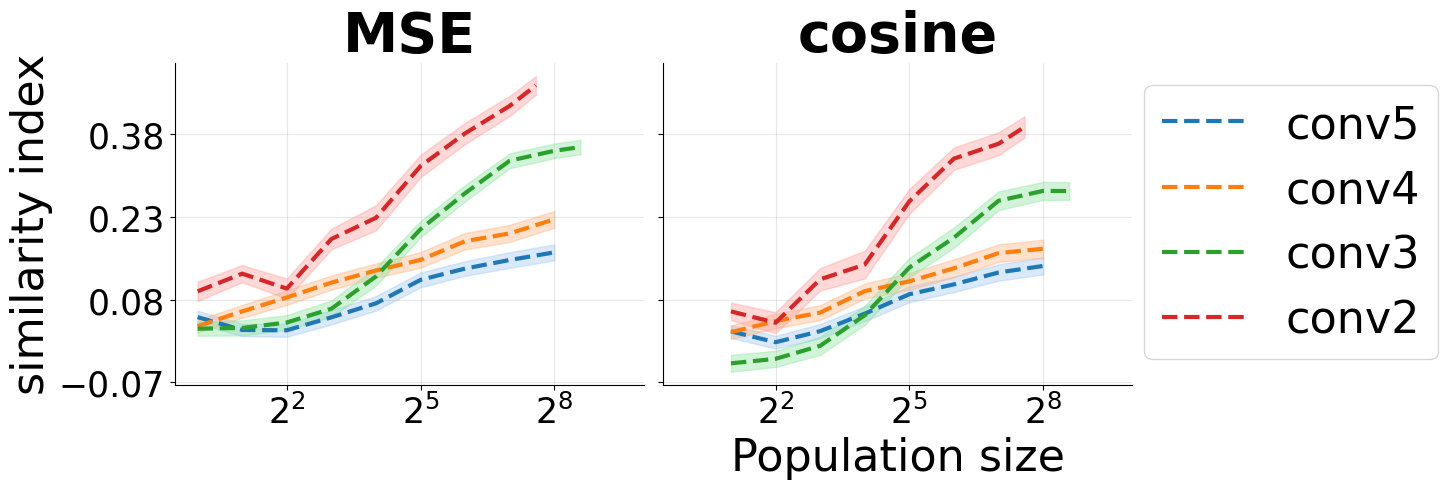

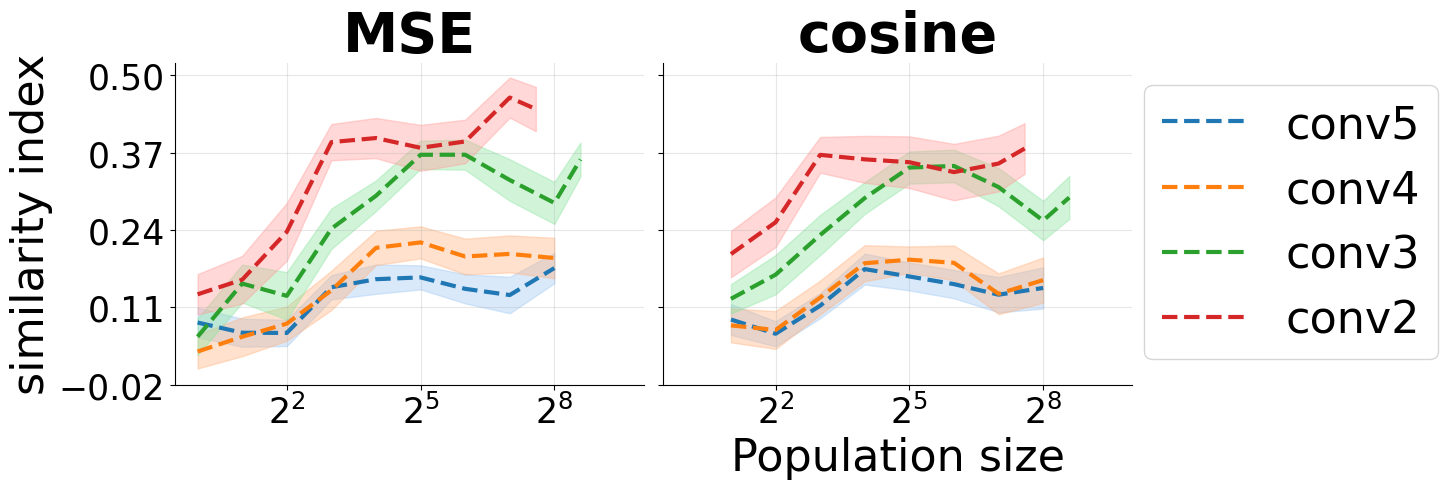

In [11]:
# inter-layer sampling, similarity vs population size all in one plot

metric_name_list = ["MSE", "cosine"]
perceptual_similarity = "sim_index_l2"# "l2_distance_normalized" # "sim_index_l2", "sim_index_l1", "l2_distance"

expriment_meta_data_df_post_hock = metadata_df_cosine.copy()
layer_short_list = ["conv5", "conv4", "conv3", "conv2"]

# set font size
title_font_size = 40
axis_font_size = 32
tick_font_size = 25

line_color = sns.color_palette()
shade_color = sns.color_palette("pastel")
for sub_pop_type in ["random", "most"]:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for j, layer_short in enumerate(layer_short_list):
        for i, metric_name in enumerate(metric_name_list):

            if sub_pop_type == "random":
            # do the mean and sem by negleting np.nan values
                mean_result =  expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].mean()
                std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].sem()
            elif sub_pop_type == "most":
                mean_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                    expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                    expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                        "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                            "pop_size")[perceptual_similarity].mean()
                std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].sem()
            mean_result_index  = mean_result.index
            mean_result  = mean_result.values
            std_result = std_result.values

            if metric_name == "cosine":
                mean_result_index = mean_result_index[1:]
                mean_result = mean_result[1:]
                std_result = std_result[1:]

            # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis and make the coloe of bars similar to the color of the line
            ax[i].plot(mean_result_index, mean_result, '--', color=line_color[j], label=layer_short, linewidth=3)
            ax[i].fill_between(mean_result_index, mean_result-std_result, mean_result+std_result,
                                color=shade_color[j], alpha=0.4, label='')
            ## add grid
            ax[i].grid(True, which='both', axis='both', alpha=0.3)

            ax[i].set_xscale('log', base=2)

            ax[i].set_title(f"{metric_name}", fontsize=title_font_size, fontweight='bold')

        # get y lims for all the subplots
        y_lims = [ax[i].get_ylim() for i in range(len(ax))]
        # define the y lim that cincludes all the subplots y lims
        y_lim = [min([y_lims[i][0] for i in range(len(ax))]), max([y_lims[i][1] for i in range(len(ax))])]
        
        if perceptual_similarity == 'l2_distance':
                ax[0].set_ylabel(f"l2 distance", fontsize=axis_font_size)
        elif perceptual_similarity == 'pixel_dist_normalized':
                ax[0].set_ylabel(f"similarity index", fontsize=axis_font_size)
        else:
            ax[0].set_ylabel(f"similarity index", fontsize=axis_font_size)
    ax[1].set_xlabel("Population size", fontsize=32)    
    # add legend to as layers names to the second subplot outside the plot        
    ax[1].legend( loc='upper right', bbox_to_anchor=(1.7, 1), fontsize=axis_font_size)
    # set the y lim for all the subplots
    for i in range(len(ax)):
        ax[i].set_ylim(y_lim)
        # make Y-tiks nicer 
        ax[i].set_yticks(np.round(np.arange(min(y_lim), max(y_lim), round((max(y_lim)-min(y_lim))/4, 2)), 2))
        ax[i].set_xlim([2**0-.3, 2**10])
        # increase the font size of the y  and x ticks
        ax[i].tick_params(axis='y', which='major', labelsize=tick_font_size)
        ax[i].tick_params(axis='x', which='major', labelsize=tick_font_size)
    # remove the y ticks labels from second subplot
    ax[1].set_yticklabels([])
    # set tight layout
    fig.tight_layout()    
    # set title for the whole figure
    save_path = os.path.join(save_root, f"{perceptual_similarity}_vx_pop_size")
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(os.path.join(save_path, f"{sub_pop_type}.png"), bbox_inches="tight", pad_inches=0)

In [ ]:
# inter-layer sampling, score vs population size all in one plot

metric_name_list = ["MSE", "cosine"]
col_name = "score" 

expriment_meta_data_df_post_hock = metadata_df_cosine.copy()
layer_short_list = ["conv5", "conv4", "conv3", "conv2"]

# set font size
title_font_size = 40
axis_font_size = 32
tick_font_size = 25

line_color = sns.color_palette()
shade_color = sns.color_palette("pastel")
for sub_pop_type in ["random", "most"]:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for j, layer_short in enumerate(layer_short_list):
        for i, metric_name in enumerate(metric_name_list):

            if sub_pop_type == "random":
            # do the mean and sem by negleting np.nan values
                mean_result =  expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size", "pop_resampling_id"])[col_name].mean().reset_index().groupby(
                                                                    "pop_size")[col_name].mean()
                std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size", "pop_resampling_id"])[col_name].mean().reset_index().groupby(
                                                                    "pop_size")[col_name].sem()
            elif sub_pop_type == "most":
                mean_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                    expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                    expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                        "trget_imge_name", "pop_size"])[col_name].mean().reset_index().groupby(
                                                            "pop_size")[col_name].mean()
                std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size"])[col_name].mean().reset_index().groupby(
                                                                    "pop_size")[col_name].sem()
            mean_result_index  = mean_result.index
            mean_result  = mean_result.values
            std_result = std_result.values

            if metric_name == "cosine":
                mean_result_index = mean_result_index[1:]
                mean_result = mean_result[1:]
                std_result = std_result[1:]

            # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis and make the coloe of bars similar to the color of the line
            
            ax[i].plot(mean_result_index, mean_result, '--', color=line_color[j], label=layer_short, linewidth=3)
            ax[i].fill_between(mean_result_index, mean_result-std_result, mean_result+std_result,
                                color=shade_color[j], alpha=0.4, label='')
            ## add grid
            ax[i].grid(True, which='both', axis='both', alpha=0.3)

            ax[i].set_xscale('log', base=2)

            ax[i].set_title(f"{metric_name}", fontsize=title_font_size, fontweight='bold')
        
    
    ax[0].set_ylabel(f"objective score", fontsize=axis_font_size)
    ax[1].set_xlabel("Population size", fontsize=32)    
    # add legend to as layers names to the second subplot outside the plot        
    ax[1].legend( loc='upper right', bbox_to_anchor=(1.7, 1), fontsize=axis_font_size)
    # set the y lim for all the subplots
    for i in range(len(ax)):
        # make tiks nicer 
        ax[i].set_xlim([2**0-.3, 2**10])
        # increase the font size of the y  and x ticks
        ax[i].tick_params(axis='y', which='major', labelsize=tick_font_size)
        ax[i].tick_params(axis='x', which='major', labelsize=tick_font_size)
    # set title for the whole figure
    save_path = os.path.join(save_root, f"score_vx_pop_size")
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(os.path.join(save_path, f"{sub_pop_type}.png"), bbox_inches="tight", pad_inches=0)

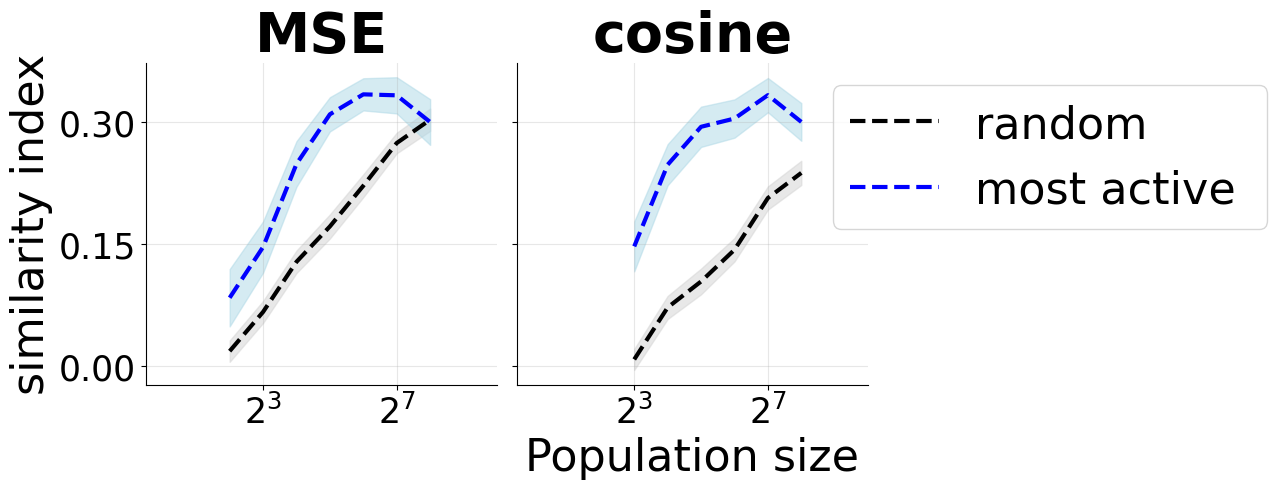

In [11]:
# inter-layer sampling, caompaire random and most seleccion for each layer
metric_name_list = ["MSE", "cosine"]
perceptual_similarity = "sim_index_l2"#sim_index_l1

expriment_meta_data_df_post_hock = metadata_df_cosine.copy()
#layer_short_list = ["conv5", "conv4", "conv3", "conv2"]
layer_short_list = [ "conv5432"]

# set font size
title_font_size = 40
axis_font_size = 32
tick_font_size = 25

for j, layer_short in enumerate(layer_short_list):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for i, metric_name in enumerate(metric_name_list):

        for sub_pop_type in ["random", "most"]: 
    # do the mean and sem by negleting np.nan values
            if sub_pop_type == "random":
                mean_result =  expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].mean()
                std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                            "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                "pop_size")[perceptual_similarity].sem()
                line_color = 'black'
                shade_color = 'lightgray'
                lable = "random"
            if sub_pop_type == "most":
                mean_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                    expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                    expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                        "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                            "pop_size")[perceptual_similarity].mean()
                std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                        expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                            "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                                "pop_size")[perceptual_similarity].sem()
                line_color = 'blue'
                shade_color = 'lightblue'
                lable = "most active "
            mean_result_index  = mean_result.index
            mean_result  = mean_result.values
            std_result = std_result.values

            if metric_name == "cosine":
                mean_result_index = mean_result_index[1:]
                mean_result = mean_result[1:]
                std_result = std_result[1:]

            if layer_short == "conv5432":
                 mean_result_index = mean_result_index * 4
            if layer_short == "conv53":
                 mean_result_index = mean_result_index * 2

            # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis and make the coloe of bars similar to the color of the line
            ax[i].plot(mean_result_index, mean_result, '--', color=line_color, label=lable, linewidth=3)
            ax[i].fill_between(mean_result_index, mean_result-std_result, mean_result+std_result,
                                color=shade_color, alpha=0.5, label='')
        ## add grid
        ax[i].grid(True, which='both', axis='both', alpha=0.3)

        ax[i].set_xscale('log', base=2)

        ax[i].set_title(f"{metric_name}", fontsize=title_font_size, fontweight='bold')

    # get y lims for all the subplots
    y_lims = [ax[i].get_ylim() for i in range(len(ax))]
    # define the y lim that cincludes all the subplots y lims
    y_lim = [min([y_lims[i][0] for i in range(len(ax))]), max([y_lims[i][1] for i in range(len(ax))])]
    
    if perceptual_similarity == 'l2_distance':
            ax[0].set_ylabel(f"l2 distance", fontsize=axis_font_size)
    if perceptual_similarity == 'pixel_dist_normalized':
            ax[0].set_ylabel(f"similarity index", fontsize=axis_font_size)
    else:
        ax[0].set_ylabel(f"similarity index", fontsize=axis_font_size)
    ax[1].set_xlabel("Population size", fontsize=32)    
    # add legend to as layers names to the second subplot outside the plot        
    ax[1].legend( loc='upper right', bbox_to_anchor=(2.2, 1), fontsize=axis_font_size)
    # set the y lim for all the subplots
    for i in range(len(ax)):
        ax[i].set_ylim(y_lim)
        # make Y-tiks nicer 
        #ax[i].set_yticks(np.round(np.arange(min(y_lim), max(y_lim), round((max(y_lim)-min(y_lim))/4, 2)),2))
        ax[i].set_yticks([0, .15, .3])
        ax[i].set_xlim([2**0-.3, 2**10])
        # increase the font size of the y  and x ticks
        ax[i].tick_params(axis='y', which='major', labelsize=tick_font_size)
        ax[i].tick_params(axis='x', which='major', labelsize=tick_font_size)
    # remove the tick labels from the second subplot
    ax[1].set_yticklabels([])
    # ser tight layout
    plt.tight_layout()

    # set title for the whole figure
    save_path = os.path.join(save_root, f"{perceptual_similarity}_vx_pop_size_random_vs_most")
    os.makedirs(save_path, exist_ok=True)

    plt.savefig(os.path.join(save_path, f"{layer_short}.png"), bbox_inches="tight", pad_inches=0)
    plt.savefig(os.path.join(save_path, f"{layer_short}.pdf"), bbox_inches="tight", pad_inches=0, dpi=300)

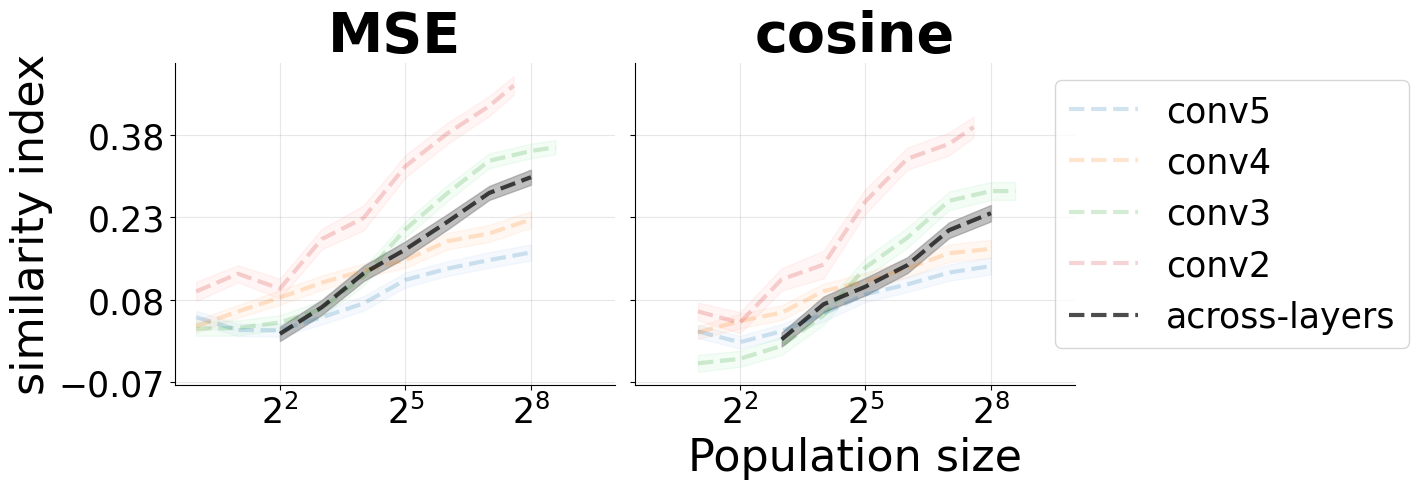

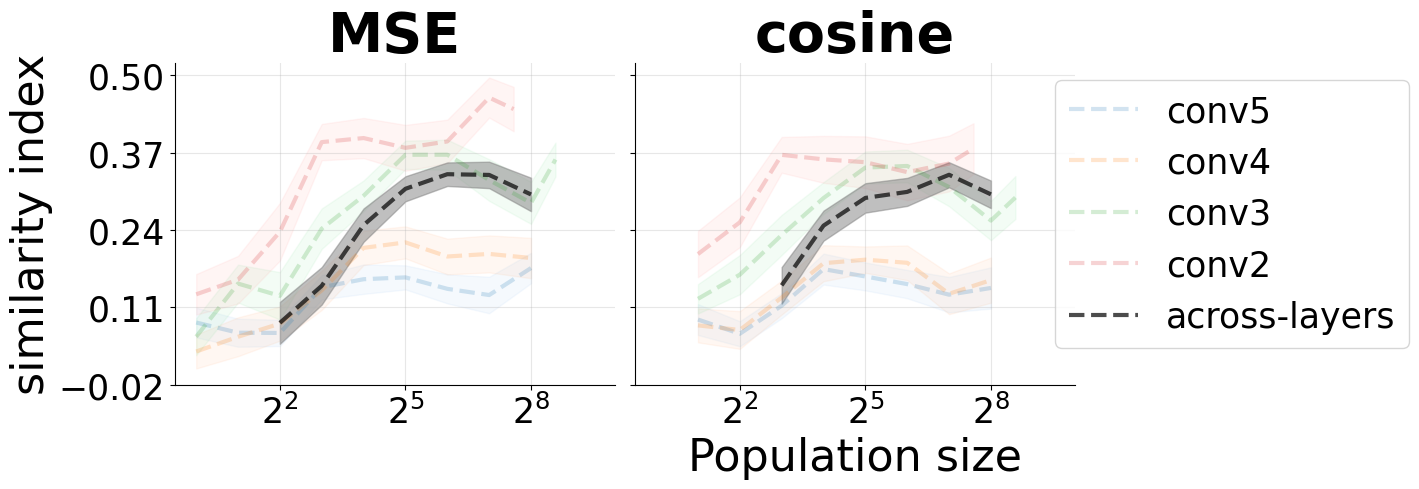

In [15]:
# intera-layer sampling, similarity vs population size for conv5432

metric_name_list = ["MSE", "cosine"]
perceptual_similarity = "sim_index_l2" # "l2_distance_normalized" # "sim_index_l2", "sim_index_l1", "l2_distance"

expriment_meta_data_df_post_hock = metadata_df_cosine.copy()
layer_short_list = ["conv5", "conv4", "conv3", "conv2"]
intrea_layer_short = "conv5432"
# set font size
title_font_size = 40
axis_font_size = 32
tick_font_size = 25
legend_font_size = 25

line_color = sns.color_palette()
shade_color = sns.color_palette("pastel")
for sub_pop_type in ["random", "most"]:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for i, metric_name in enumerate(metric_name_list):
        for j, layer_short in enumerate(layer_short_list):
        
            if sub_pop_type == "random":
            # do the mean and sem by negleting np.nan values
                mean_result =  expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].mean()
                std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].sem()
            elif sub_pop_type == "most":
                mean_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                    expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                    expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                        "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                            "pop_size")[perceptual_similarity].mean()
                std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].sem()
            mean_result_index  = mean_result.index
            mean_result  = mean_result.values
            std_result = std_result.values

            if metric_name == "cosine":
                mean_result_index = mean_result_index[1:]
                mean_result = mean_result[1:]
                std_result = std_result[1:]
            
            # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis and make the coloe of bars similar to the color of the line
            ax[i].plot(mean_result_index, mean_result, '--', color=line_color[j], label=layer_short, alpha=0.2, linewidth=3)
            ax[i].fill_between(mean_result_index, mean_result-std_result, mean_result+std_result,
                                color=shade_color[j], alpha=0.1, label='')
        #--- add entra layer to plot
        if sub_pop_type == "random":
            # do the mean and sem by negleting np.nan values
            mean_result =  expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                    (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                        expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                            "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                "pop_size")[perceptual_similarity].mean()
            std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                    (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                        expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                            "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                "pop_size")[perceptual_similarity].sem()
        elif sub_pop_type == "most":
            mean_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                        "pop_size")[perceptual_similarity].mean()
            std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                    (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                        expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                            "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                                "pop_size")[perceptual_similarity].sem()
        
        mean_result_index  = mean_result.index*4
        mean_result  = mean_result.values
        std_result = std_result.values

        if metric_name == "cosine":
            mean_result_index = mean_result_index[1:]
            mean_result = mean_result[1:]
            std_result = std_result[1:]
            
        # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis and make the coloe of bars similar to the color of the line
        ax[i].plot(mean_result_index, mean_result, '--', color='black', label="across-layers", alpha=.7, linewidth=3)
        ax[i].fill_between(mean_result_index, mean_result-std_result, mean_result+std_result,
                            color='gray', alpha=0.5, label='')
        #----
        ## add grid
        ax[i].grid(True, which='both', axis='both', alpha=0.3)

        ax[i].set_xscale('log', base=2)

        ax[i].set_title(f"{metric_name}", fontsize=title_font_size, fontweight='bold')

        # get y lims for all the subplots
        y_lims = [ax[i].get_ylim() for i in range(len(ax))]
        # define the y lim that cincludes all the subplots y lims
        y_lim = [min([y_lims[i][0] for i in range(len(ax))]), max([y_lims[i][1] for i in range(len(ax))])]
        

    if perceptual_similarity == 'l2_distance':
        ax[0].set_ylabel(f"l2 distance", fontsize=axis_font_size)
    elif perceptual_similarity == 'pixel_dist_normalized':
        ax[0].set_ylabel(f"similarity index", fontsize=axis_font_size)
    else:
        ax[0].set_ylabel(f"similarity index", fontsize=axis_font_size)
    ax[1].set_xlabel("Population size", fontsize=32)    
    # add legend to as layers names to the second subplot outside the plot        
    ax[1].legend( loc='upper right', bbox_to_anchor=(1.8, 1), fontsize=legend_font_size)
    # set the y lim for all the subplots
    for i in range(len(ax)):
        ax[i].set_ylim(y_lim)
        # make Y-tiks nicer 
        ax[i].set_yticks(np.round(np.arange(min(y_lim), max(y_lim), round((max(y_lim)-min(y_lim))/4, 2)),2))
        ax[i].set_xlim([2**0-.3, 2**10])
        # increase the font size of the y  and x ticks
        ax[i].tick_params(axis='y', which='major', labelsize=tick_font_size)
        ax[i].tick_params(axis='x', which='major', labelsize=tick_font_size)
    # remove the tick labels from the second subplot
    ax[1].set_yticklabels([])
    # ser tight layout
    plt.tight_layout()
    save_path = os.path.join(save_root, f"{perceptual_similarity}_vx_pop_size_across_layers_recording", f"{intrea_layer_short}")
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(os.path.join(save_path, f"{sub_pop_type}.png"), bbox_inches="tight", pad_inches=0)

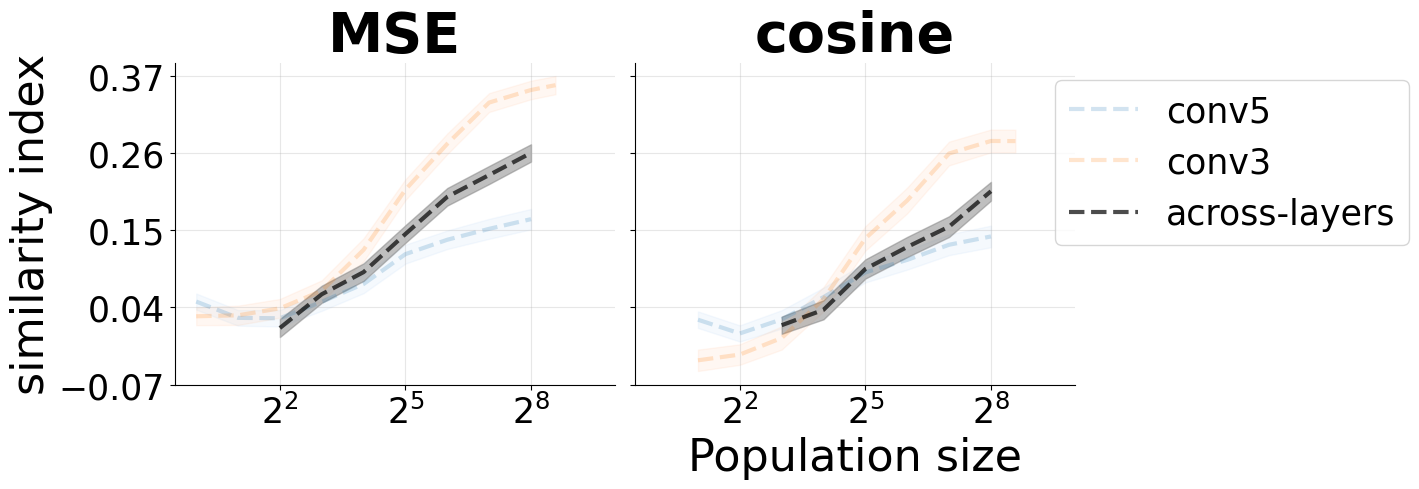

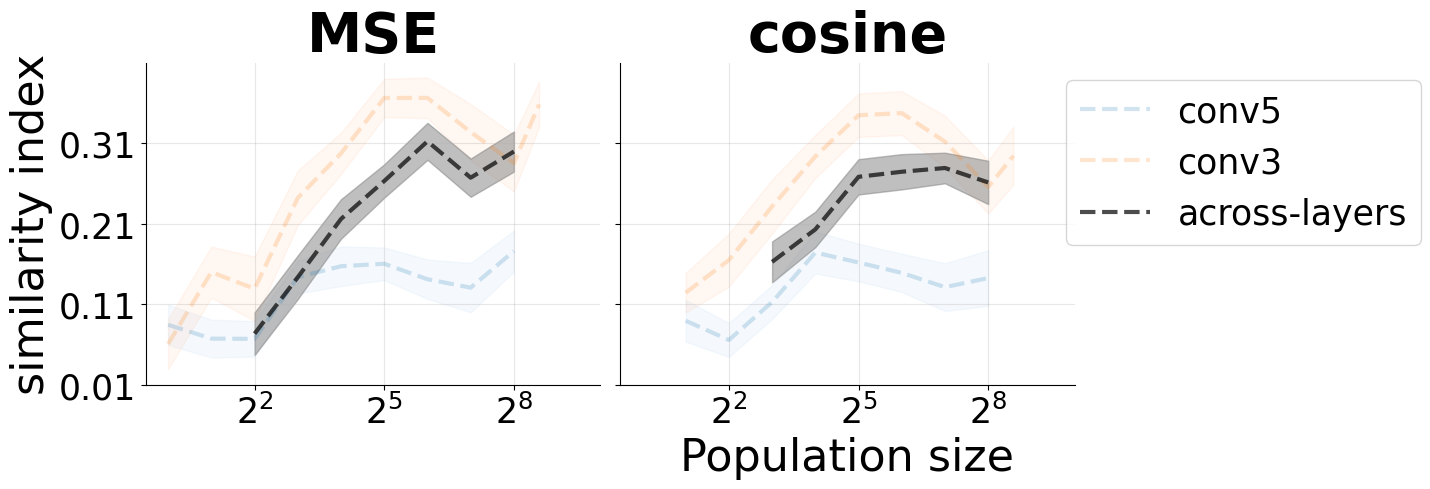

In [17]:
# intera-layer sampling, similarity vs population size for conv53

metric_name_list = ["MSE", "cosine"]
perceptual_similarity = "sim_index_l2"#"pixel_dist_normalized" # "LPIPS_similarity"

expriment_meta_data_df_post_hock = metadata_df_cosine.copy()
layer_short_list = ["conv5", "conv3"]
intrea_layer_short = "conv53"
# set font size
title_font_size = 40
axis_font_size = 32
tick_font_size = 25
legend_font_size = 25

line_color = sns.color_palette()
shade_color = sns.color_palette("pastel")
for sub_pop_type in ["random", "most"]:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for i, metric_name in enumerate(metric_name_list):
        for j, layer_short in enumerate(layer_short_list):
        
            if sub_pop_type == "random":
            # do the mean and sem by negleting np.nan values
                mean_result =  expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].mean()
                std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].sem()
            elif sub_pop_type == "most":
                mean_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                    expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                    expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                        "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                            "pop_size")[perceptual_similarity].mean()
                std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].sem()
            mean_result_index  = mean_result.index
            mean_result  = mean_result.values
            std_result = std_result.values

            if metric_name == "cosine":
                mean_result_index = mean_result_index[1:]
                mean_result = mean_result[1:]
                std_result = std_result[1:]
            
            # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis and make the coloe of bars similar to the color of the line
            ax[i].plot(mean_result_index, mean_result, '--', color=line_color[j], label=layer_short, alpha=0.2, linewidth=3)
            ax[i].fill_between(mean_result_index, mean_result-std_result, mean_result+std_result,
                                color=shade_color[j], alpha=0.1, label='')
        #--- add entra layer to plot
        if sub_pop_type == "random":
            # do the mean and sem by negleting np.nan values
            mean_result =  expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                    (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                        expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                            "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                "pop_size")[perceptual_similarity].mean()
            std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                    (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                        expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                            "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                "pop_size")[perceptual_similarity].sem()
        elif sub_pop_type == "most":
            mean_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                        "pop_size")[perceptual_similarity].mean()
            std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                    (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                        expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                            "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                                "pop_size")[perceptual_similarity].sem()
        
        mean_result_index  = mean_result.index*2
        mean_result  = mean_result.values
        std_result = std_result.values

        if metric_name == "cosine":
            mean_result_index = mean_result_index[1:]
            mean_result = mean_result[1:]
            std_result = std_result[1:]
            
        # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis and make the coloe of bars similar to the color of the line
        ax[i].plot(mean_result_index, mean_result, '--', color='black', label="across-layers", alpha=.7, linewidth=3)
        ax[i].fill_between(mean_result_index, mean_result-std_result, mean_result+std_result,
                            color='gray', alpha=0.5, label='')
        #----
        ## add grid
        ax[i].grid(True, which='both', axis='both', alpha=0.3)

        ax[i].set_xscale('log', base=2)

        ax[i].set_title(f"{metric_name}", fontsize=title_font_size, fontweight='bold')

        # get y lims for all the subplots
        y_lims = [ax[i].get_ylim() for i in range(len(ax))]
        # define the y lim that cincludes all the subplots y lims
        y_lim = [min([y_lims[i][0] for i in range(len(ax))]), max([y_lims[i][1] for i in range(len(ax))])]
        

    if perceptual_similarity == 'l2_distance':
        ax[0].set_ylabel(f"l2 distance", fontsize=axis_font_size)
    elif perceptual_similarity == 'pixel_dist_normalized':
        ax[0].set_ylabel(f"similarity index", fontsize=axis_font_size)
    else:
        ax[0].set_ylabel(f"similarity index", fontsize=axis_font_size)
    ax[1].set_xlabel("Population size", fontsize=32)    
    # add legend to as layers names to the second subplot outside the plot        
    ax[1].legend( loc='upper right', bbox_to_anchor=(1.8, 1), fontsize=legend_font_size)
    # set the y lim for all the subplots
    for i in range(len(ax)):
        ax[i].set_ylim(y_lim)
        # make Y-tiks nicer 
        ax[i].set_yticks(np.round(np.arange(min(y_lim), max(y_lim), round((max(y_lim)-min(y_lim))/4, 2)),2))
        ax[i].set_xlim([2**0-.3, 2**10])
        # increase the font size of the y  and x ticks
        ax[i].tick_params(axis='y', which='major', labelsize=tick_font_size)
        ax[i].tick_params(axis='x', which='major', labelsize=tick_font_size)
    # remove the tick labels from the second subplot
    ax[1].set_yticklabels([])
    # ser tight layout
    plt.tight_layout()
    
    save_path = os.path.join(save_root, f"{perceptual_similarity}_vx_pop_size_across_layers_recording", f"{intrea_layer_short}")
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(os.path.join(save_path, f"{sub_pop_type}.png"), bbox_inches="tight", pad_inches=0)

In [ ]:
# intera-layer sampling, score vs population size for conv5432

metric_name_list = ["MSE", "cosine"]
perceptual_similarity = "score"#"pixel_dist_normalized" # "LPIPS_similarity"

expriment_meta_data_df_post_hock = metadata_df_cosine.copy()
layer_short_list = ["conv5", "conv4", "conv3", "conv2"]
intrea_layer_short = "conv5432"
# set font size
title_font_size = 40
axis_font_size = 32
tick_font_size = 25
legend_font_size = 25

line_color = sns.color_palette()
shade_color = sns.color_palette("pastel")
for sub_pop_type in ["random", "most"]:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for i, metric_name in enumerate(metric_name_list):
        for j, layer_short in enumerate(layer_short_list):
        
            if sub_pop_type == "random":
            # do the mean and sem by negleting np.nan values
                mean_result =  expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].mean()
                std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].sem()
            elif sub_pop_type == "most":
                mean_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                    expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                    expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                        "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                            "pop_size")[perceptual_similarity].mean()
                std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].sem()
            mean_result_index  = mean_result.index
            mean_result  = mean_result.values
            std_result = std_result.values

            if metric_name == "cosine":
                mean_result_index = mean_result_index[1:]
                mean_result = mean_result[1:]
                std_result = std_result[1:]
            
            # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis and make the coloe of bars similar to the color of the line
            ax[i].plot(mean_result_index, mean_result, '--', color=line_color[j], label=layer_short, alpha=0.2, linewidth=3)
            ax[i].fill_between(mean_result_index, mean_result-std_result, mean_result+std_result,
                                color=shade_color[j], alpha=0.1, label='')
        #--- add entra layer to plot
        if sub_pop_type == "random":
            # do the mean and sem by negleting np.nan values
            mean_result =  expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                    (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                        expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                            "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                "pop_size")[perceptual_similarity].mean()
            std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                    (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                        expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                            "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                "pop_size")[perceptual_similarity].sem()
        elif sub_pop_type == "most":
            mean_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                        "pop_size")[perceptual_similarity].mean()
            std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                    (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                        expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                            "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                                "pop_size")[perceptual_similarity].sem()
        
        mean_result_index  = mean_result.index*4
        mean_result  = mean_result.values
        std_result = std_result.values

        if metric_name == "cosine":
            mean_result_index = mean_result_index[1:]
            mean_result = mean_result[1:]
            std_result = std_result[1:]
            
        # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis and make the coloe of bars similar to the color of the line
        ax[i].plot(mean_result_index, mean_result, '--', color='black', label="across-layers", alpha=.7, linewidth=3)
        ax[i].fill_between(mean_result_index, mean_result-std_result, mean_result+std_result,
                            color='gray', alpha=0.5, label='')
        #----
        ## add grid
        ax[i].grid(True, which='both', axis='both', alpha=0.3)

        ax[i].set_xscale('log', base=2)

        ax[i].set_title(f"{metric_name}", fontsize=title_font_size, fontweight='bold')

        

    if perceptual_similarity == 'l2_distance':
                ax[0].set_ylabel(f"l2 distance", fontsize=axis_font_size)
    if perceptual_similarity == 'pixel_dist_normalized':
            ax[0].set_ylabel(f"similarity index", fontsize=axis_font_size)
    else:
        ax[0].set_ylabel(f"{perceptual_similarity}", fontsize=axis_font_size)
    ax[1].set_xlabel("Population size", fontsize=32)    
    # add legend to as layers names to the second subplot outside the plot        
    ax[1].legend( loc='upper right', bbox_to_anchor=(1.8, 1), fontsize=legend_font_size)
    # set the y lim for all the subplots
    for i in range(len(ax)):
        # make tiks nicer 
        ax[i].set_xlim([2**0-.3, 2**10])
        # increase the font size of the y  and x ticks
        ax[i].tick_params(axis='y', which='major', labelsize=tick_font_size)
        ax[i].tick_params(axis='x', which='major', labelsize=tick_font_size)
    save_path = os.path.join(save_root, f"{perceptual_similarity}_vx_pop_size_across_layers_recording", f"{intrea_layer_short}")
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(os.path.join(save_path, f"{sub_pop_type}.png"), bbox_inches="tight", pad_inches=0)

In [ ]:
# intera-layer sampling, SCORE vs population size for conv53

metric_name_list = ["MSE", "cosine"]
perceptual_similarity = "score"#"pixel_dist_normalized" # "LPIPS_similarity"

expriment_meta_data_df_post_hock = metadata_df_cosine.copy()
layer_short_list = ["conv5", "conv3"]
intrea_layer_short = "conv53"
# set font size
title_font_size = 40
axis_font_size = 32
tick_font_size = 25
legend_font_size = 25

line_color = sns.color_palette()
shade_color = sns.color_palette("pastel")
for sub_pop_type in ["random", "most"]:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    for i, metric_name in enumerate(metric_name_list):
        for j, layer_short in enumerate(layer_short_list):
        
            if sub_pop_type == "random":
            # do the mean and sem by negleting np.nan values
                mean_result =  expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].mean()
                std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].sem()
            elif sub_pop_type == "most":
                mean_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                    expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                    expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                        "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                            "pop_size")[perceptual_similarity].mean()
                std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                        (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                            expriment_meta_data_df_post_hock["layer_short"]==layer_short) & (
                                                            expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                                "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                                    "pop_size")[perceptual_similarity].sem()
            mean_result_index  = mean_result.index
            mean_result  = mean_result.values
            std_result = std_result.values

            if metric_name == "cosine":
                mean_result_index = mean_result_index[1:]
                mean_result = mean_result[1:]
                std_result = std_result[1:]
            
            # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis and make the coloe of bars similar to the color of the line
            ax[i].plot(mean_result_index, mean_result, '--', color=line_color[j], label=layer_short, alpha=0.2, linewidth=3)
            ax[i].fill_between(mean_result_index, mean_result-std_result, mean_result+std_result,
                                color=shade_color[j], alpha=0.1, label='')
        #--- add entra layer to plot
        if sub_pop_type == "random":
            # do the mean and sem by negleting np.nan values
            mean_result =  expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                    (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                        expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                            "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                "pop_size")[perceptual_similarity].mean()
            std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                    (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                        expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                            "trget_imge_name", "pop_size", "pop_resampling_id"])[perceptual_similarity].mean().reset_index().groupby(
                                                                "pop_size")[perceptual_similarity].sem()
        elif sub_pop_type == "most":
            mean_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                            (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                    "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                        "pop_size")[perceptual_similarity].mean()
            std_result = expriment_meta_data_df_post_hock[(expriment_meta_data_df_post_hock["output_type"] == "best_gen_imgs_RF_masked") & \
                                                    (expriment_meta_data_df_post_hock["similarity_metric"]==metric_name) & (
                                                        expriment_meta_data_df_post_hock["layer_short"]==intrea_layer_short) & (
                                                        expriment_meta_data_df_post_hock["sub_pop_type"] == sub_pop_type)].groupby([
                                                            "trget_imge_name", "pop_size"])[perceptual_similarity].mean().reset_index().groupby(
                                                                "pop_size")[perceptual_similarity].sem()
        
        mean_result_index  = mean_result.index*2
        mean_result  = mean_result.values
        std_result = std_result.values

        if metric_name == "cosine":
            mean_result_index = mean_result_index[1:]
            mean_result = mean_result[1:]
            std_result = std_result[1:]
            
        # plot the results using subplots and erorbar and conected dot and log 2 scale for the x axis and make the coloe of bars similar to the color of the line
        ax[i].plot(mean_result_index, mean_result, '--', color='black', label="across-layers", alpha=.7, linewidth=3)
        ax[i].fill_between(mean_result_index, mean_result-std_result, mean_result+std_result,
                            color='gray', alpha=0.5, label='')
        #----
        ## add grid
        ax[i].grid(True, which='both', axis='both', alpha=0.3)

        ax[i].set_xscale('log', base=2)

        ax[i].set_title(f"{metric_name}", fontsize=title_font_size, fontweight='bold')


    if perceptual_similarity == 'l2_distance':
                ax[0].set_ylabel(f"l2 distance", fontsize=axis_font_size)
    if perceptual_similarity == 'pixel_dist_normalized':
            ax[0].set_ylabel(f"similarity index", fontsize=axis_font_size)
    else:
        ax[0].set_ylabel(f"{perceptual_similarity}", fontsize=axis_font_size)
    ax[1].set_xlabel("Population size", fontsize=32)    
    # add legend to as layers names to the second subplot outside the plot        
    ax[1].legend( loc='upper right', bbox_to_anchor=(1.8, 1), fontsize=legend_font_size)
    # set the y lim for all the subplots
    for i in range(len(ax)):
        # make Y-tiks nicer 
        ax[i].set_xlim([2**0-.3, 2**10])
        # increase the font size of the y  and x ticks
        ax[i].tick_params(axis='y', which='major', labelsize=tick_font_size)
        ax[i].tick_params(axis='x', which='major', labelsize=tick_font_size)
    save_path = os.path.join(save_root, f"{perceptual_similarity}_vx_pop_size_across_layers_recording", f"{intrea_layer_short}")
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(os.path.join(save_path, f"{sub_pop_type}.png"), bbox_inches="tight", pad_inches=0)